In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
from torch_geometric.data import Data

import rdkit
import rdkit.Chem as Chem

from collections import defaultdict

In [3]:
dir_data = './data' 
dir_output = './outputs/rgcn'

In [4]:
if not os.path.exists(dir_output):
        os.makedirs(f'{dir_output}/train')
        os.mkdir(f'{dir_output}/dev')
        os.mkdir(f'{dir_output}/test')

In [6]:
def create_encoders(df):
    """
    데이터프레임 (df)의 각 row를 방문하여, 원자, 연결 타입, 연결 스테레오에 대한 LabelEncoder를 만들어주는 함수
    """
    encoder_atom = defaultdict(lambda : len(encoder_atom))
    encoder_bond_type = defaultdict(lambda : len(encoder_bond_type))
    encoder_bond_stereo = defaultdict(lambda : len(encoder_bond_stereo))
    encoder_bond_type_stereo = defaultdict(lambda : len(encoder_bond_type_stereo))
        
    target = df['SMILES'].values
    total_num = len(target)
    for i, smiles in enumerate(target):
        print(f'Creating the label encoders for atoms, bond_type, and bond_stereo ... [{i + 1} / {total_num}] done !', end='\r')
        m = Chem.MolFromSmiles(smiles)
        m = Chem.AddHs(m)
        
        for atom in m.GetAtoms():
            encoder_atom[atom.GetAtomicNum()]
            
        for bond in m.GetBonds():
            encoder_bond_type[bond.GetBondTypeAsDouble()]
            encoder_bond_stereo[bond.GetStereo()]
            encoder_bond_type_stereo[(bond.GetBondTypeAsDouble(), bond.GetStereo())]
        
    return encoder_atom, encoder_bond_type, encoder_bond_stereo, encoder_bond_type_stereo

In [9]:
encoder_atom, encoder_bond_type, encoder_bond_stereo, encoder_bond_type_stereo = create_encoders(full)

In [10]:
def row2data(row, encoder_atom, encoder_bond_type, encoder_bond_stereo, encoder_bond_type_stereo):
    smiles = row.SMILES
    y = row.y
    
    m = Chem.MolFromSmiles(smiles)
    m = Chem.AddHs(m)
    
    # Creating node feature vector
    num_nodes = len(list(m.GetAtoms()))
    x = np.zeros((num_nodes, len(encoder_atom.keys())))
    for i in m.GetAtoms():
        x[i.GetIdx(), encoder_atom[i.GetAtomicNum()]] = 1
    
    x = torch.from_numpy(x).float()

    # Creating edge_index and edge_type
    i = 0
    num_edges = 2 * len(list(m.GetBonds()))
    edge_index = np.zeros((2, num_edges), dtype=np.int64)
    edge_type = np.zeros((num_edges, ), dtype=np.int64)
    for edge in m.GetBonds():
        # Getting bond information
        u = min(edge.GetBeginAtomIdx(), edge.GetEndAtomIdx())
        v = max(edge.GetBeginAtomIdx(), edge.GetEndAtomIdx())
        bond_type = edge.GetBondTypeAsDouble()
        bond_stereo = edge.GetStereo()
        bond_label = encoder_bond_type_stereo[(bond_type, bond_stereo)]

        # Storing information
        edge_index[0, i] = u
        edge_index[1, i] = v
        edge_index[0, i + 1] = v
        edge_index[1, i + 1] = u
        edge_type[i] = bond_label
        edge_type[i + 1] = bond_label
        i += 2
        
    edge_index = torch.from_numpy(edge_index)    
    edge_type = torch.from_numpy(edge_type)

    # Creating y
    y = torch.tensor([y]).float()
    
    # Wrapping all together
    data = Data(
        x=x, 
        edge_index=edge_index, 
        edge_type=edge_type,
        y=y, 
        uid=row.uid
    )
    
    return data

In [11]:
for i, row in full.iterrows():
    print(f'Converting each data into torch.Data ... [{i+1} / {len(full)}] done !', end='\r')
    data = row2data(row, encoder_atom, encoder_bond_type, encoder_bond_stereo, encoder_bond_type_stereo)

    fpath = f'{dir_output}/{row.folder}/{row.uid}.pt'
    torch.save(data, fpath)

In [2]:
dir_data = './outputs/rgcn'
seed = 42

# Base model
# model architecture 
num_node_features = 13  # 원자개수 (RGCN의 입력 노드 특징 벡터의 차원)
node_embedding_dim = 256  # 각 원자들을 나타내는 임베딩 벡터의 차원 수
hidden_channels = (256, 256, 256, 256, 256, 256, 256, 256)  # 각 RGCN 레이어가 만드는 hidden state 벡터의 차원 수
hidden_dims = (1024, 512)  # 각 MLP 레이어가 만드는 hidden state 벡터의 차원 수
dropout = 0.3

# training
lr = 0.0001
n_epochs = 25
batch_size = 128

In [3]:
from glob import glob  # 폴더 안에 있는 파일들의 이름을 리스트 형태로 만들어주는 모듈

import time
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.nn import RGCNConv, global_add_pool
from torch_geometric.data import DataLoader, InMemoryDataset

In [4]:
# https://pytorch-geometric.readthedocs.io/en/latest/modules/data.html
class GNNDataset(InMemoryDataset):
    """
    폴더 안에 있는 tgm.nn.data.Data를 불러오는 함수
    """
    def __init__(self, root):
        super(GNNDataset, self).__init__(root, None, None)
        self.data, self.slices = torch.load(self.processed_paths[0])
    
    @property
    def raw_file_names(self):
        return []
    
    @property
    def processed_file_names(self):
        return ['data.pt']
    
    def download(self):
        pass
    
    def process(self):
        data_list = glob(f'{self.root}/*.pt')
        data_list = list(map(torch.load, data_list))
        data, slices = self.collate(data_list)
        torch.save((data, slices), self.processed_paths[0])

In [5]:
torch.manual_seed(42)

dataset = GNNDataset(f'{dir_data}/train')

train_dataset = dataset[:27000]
valid_dataset = dataset[27000:]
dev_dataset = GNNDataset(f'{dir_data}/dev')
test_dataset = GNNDataset(f'{dir_data}/test')

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
dev_loader = DataLoader(dev_dataset, batch_size=1, shuffle=False)

C:\Users\Tiger\anaconda3\envs\project_5\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


In [6]:
# https://pytorch-geometric.readthedocs.io/en/latest/modules/nn.html

class NodeEncoder(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(NodeEncoder, self).__init__()
        self.encoder = nn.Linear(input_dim, embedding_dim)

    def forward(self, x):
        return self.encoder(x)


class RGCNSkipConnection(torch.nn.Module):
    def __init__(self, hidden_channels, hidden_dims, num_node_features=13, node_embedding_dim=256, dropout=0.3):
        super(RGCNSkipConnection, self).__init__()
        self.node_encoder = NodeEncoder(num_node_features, node_embedding_dim)
        self.prelu = nn.PReLU()
        self.dropout = nn.Dropout(dropout)
        
        # GCN
        self.conv_layers = nn.ModuleList()
        for i in range(len(hidden_channels)):
            if i == 0:
                conv = RGCNConv(node_embedding_dim, hidden_channels[i], num_relations=6, aggr='add')
            else:
                conv = RGCNConv(hidden_channels[i - 1], hidden_channels[i], num_relations=6, aggr='add')
            self.conv_layers.append(conv)

        self.graph_pooling = nn.Sequential(
            nn.Linear(hidden_channels[-1], hidden_channels[-1]),
            nn.ReLU(),
            nn.Linear(hidden_channels[-1], hidden_channels[-1]),
        )

        # MLP
        self.fc_layers = nn.ModuleList()
        for i in range(len(hidden_dims)):
            if i == 0:
                fc = nn.Linear(hidden_channels[-1], hidden_dims[i])
            else:
                fc = nn.Linear(hidden_dims[i - 1], hidden_dims[i])
            self.fc_layers.append(fc)
        self.out = nn.Linear(hidden_dims[-1], 1)
       
    def forward(self, x, edge_index, edge_type, batch):
        # 1. Encode each atom to a vector representation
        x = self.node_encoder(x)

        # 2. Obtain node embeddings through gnn
        for i, conv in enumerate(self.conv_layers):
            skip = x
            x = conv(x, edge_index, edge_type)
            x = self.prelu(x + skip)
            x = F.normalize(x, 2, 1)
        
        # 3. graph pooling
        x = self.graph_pooling(x)
        x = global_add_pool(x, batch)  # [batch_size, hidden_channels]
        
        # 4. Readout phase
        for i, fc in enumerate(self.fc_layers):
            x = fc(x) 
            x = self.dropout(x)
            x = F.relu(x)

        # 5. Final prediction
        x = F.relu(self.out(x))
        
        return x

In [7]:
model = RGCNSkipConnection(hidden_channels, hidden_dims, num_node_features, node_embedding_dim, dropout=dropout)
model

RGCNSkipConnection(
  (node_encoder): NodeEncoder(
    (encoder): Linear(in_features=13, out_features=256, bias=True)
  )
  (prelu): PReLU(num_parameters=1)
  (dropout): Dropout(p=0.3, inplace=False)
  (conv_layers): ModuleList(
    (0): RGCNConv(256, 256, num_relations=6)
    (1): RGCNConv(256, 256, num_relations=6)
    (2): RGCNConv(256, 256, num_relations=6)
    (3): RGCNConv(256, 256, num_relations=6)
    (4): RGCNConv(256, 256, num_relations=6)
    (5): RGCNConv(256, 256, num_relations=6)
    (6): RGCNConv(256, 256, num_relations=6)
    (7): RGCNConv(256, 256, num_relations=6)
  )
  (graph_pooling): Sequential(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): ReLU()
    (2): Linear(in_features=256, out_features=256, bias=True)
  )
  (fc_layers): ModuleList(
    (0): Linear(in_features=256, out_features=1024, bias=True)
    (1): Linear(in_features=1024, out_features=512, bias=True)
  )
  (out): Linear(in_features=512, out_features=1, bias=True)
)

In [8]:
class AverageMeter:
    '''
    Compute and store the average and current value
    '''
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [9]:
class MSE_AverageMeter:
    '''
    Compute and store the MSE average and current value
    '''
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [10]:
class RGCNSolver:
    def __init__(self, model, lr, n_epochs, device=None):
        self.model = model
        self.device = device
        self.n_epochs = n_epochs
        
        self.criterion = torch.nn.L1Loss() 
        self.mse = torch.nn.MSELoss(reduction='none')
        self.params = [p for p in self.model.parameters() if p.requires_grad]
        self.optimizer = torch.optim.AdamW(self.params, lr=lr)
        self.model.to(self.device)
        self.history = {'train_loss': [], 'valid_loss': [], 'valid_mse': [], 'dev_loss': [], 'dev_mse': []}
        self.predict = {'pred' : [], 'true' : []}

    def fit(self, train_loader, valid_loader, dev_loader):
        for epoch in range(self.n_epochs):
            # training phase
            t = time.time()
            train_loss = self.train_one_epoch(train_loader)
            
            # validation phase
            valid_loss, valid_mse = self.evaluate(valid_loader)
            dev_loss, dev_mse = self.evaluate(dev_loader)
            
            message = f"[Epoch {epoch}] "
            message += f"Elapsed time: {time.time() - t:.3f} | "
            message += f"Train loss: {train_loss.avg:.5f} | "
            message += f"Validation loss: {valid_loss.avg:.5f} | "
            message += f"Validation mse: {valid_mse.avg:.5f} | "
            message += '\n'
            message += f"Dev loss: {dev_loss.avg:.5f} |"
            message += f"Dev mse: {dev_mse.avg:.5f} |"
            print(message)
            self.history['train_loss'].append(train_loss.avg)
            self.history['valid_loss'].append(valid_loss.avg)
            self.history['valid_mse'].append(valid_mse.avg)
            self.history['dev_loss'].append(dev_loss.avg)
            self.history['dev_mse'].append(dev_mse.avg)
             
    def train_one_epoch(self, loader):
        self.model.train()
        summary_loss = AverageMeter()
        t = time.time()
        
        for step, data in enumerate(loader):
            print(
                f'Train step {(step + 1)} / {len(loader)} | ' +
                f'Summary loss: {summary_loss.avg:.5f} |' +
                f'Time: {time.time() - t:.3f} |', end='\r'
            )
            data.to(self.device)
            
            self.optimizer.zero_grad()
            y_pred = self.model(data.x, data.edge_index, data.edge_type, data.batch)
            loss = self.criterion(y_pred, data.y.unsqueeze(1))
            loss.backward()
            self.optimizer.step()
            
            summary_loss.update(loss.detach().item(), data.num_graphs)
            
        return summary_loss
    
    def evaluate(self, loader):
        self.model.eval()
        summary_loss = AverageMeter()
        summary_mse = MSE_AverageMeter()
        t = time.time()
        
        with torch.no_grad():
            for step, data in enumerate(loader):
                data.to(self.device)
                
                y_pred = self.model(data.x, data.edge_index, data.edge_type, data.batch)
                loss = self.criterion(y_pred, data.y.unsqueeze(1))
                mse = torch.sum(self.mse(y_pred, data.y.unsqueeze(1)), dim=0)
                self.predict['pred'].extend(y_pred)
                self.predict['true'].extend(data.y.unsqueeze(1))
                summary_loss.update(loss.detach().item(), data.num_graphs)
                summary_mse.update(mse.detach().item(), data.num_graphs)
                
        return summary_loss, summary_mse

In [11]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
solver = RGCNSolver(model, lr, n_epochs, device)
solver.fit(train_loader, valid_loader, dev_loader)

[Epoch 0] Elapsed time: 15.272 | Train loss: 0.36340 | Validation loss: 0.39519 | Validation mse: 35.50444 | 
Dev loss: 0.87945 |Dev mse: 0.95955 |
[Epoch 1] Elapsed time: 12.488 | Train loss: 0.31761 | Validation loss: 0.35920 | Validation mse: 29.39635 | 
Dev loss: 0.66768 |Dev mse: 0.57480 |
[Epoch 2] Elapsed time: 12.408 | Train loss: 0.27777 | Validation loss: 0.31142 | Validation mse: 21.33831 | 
Dev loss: 0.71288 |Dev mse: 0.59625 |
[Epoch 3] Elapsed time: 12.358 | Train loss: 0.25555 | Validation loss: 0.30060 | Validation mse: 20.26148 | 
Dev loss: 0.64860 |Dev mse: 0.48504 |
[Epoch 4] Elapsed time: 12.326 | Train loss: 0.23872 | Validation loss: 0.25634 | Validation mse: 13.76678 | 
Dev loss: 0.44700 |Dev mse: 0.22977 |
[Epoch 5] Elapsed time: 11.989 | Train loss: 0.22570 | Validation loss: 0.27559 | Validation mse: 17.04263 | 
Dev loss: 0.61773 |Dev mse: 0.42907 |
[Epoch 6] Elapsed time: 12.798 | Train loss: 0.21875 | Validation loss: 0.24560 | Validation mse: 13.50609 | 
De

In [15]:
def moving_average(x, window_size=10):
    return [np.mean(x[i:i + window_size]) for i in range(len(x) - window_size + 1)]

def plotting_learning_curve(history, window_size=10):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    epochs = np.arange(len(history['train_loss'])) + 1
    
    ax.plot(epochs[:-window_size + 1], moving_average(history['train_loss'], window_size), label='train_loss')
    ax.plot(epochs[:-window_size + 1], moving_average(history['valid_loss'], window_size), label='valid_loss')
    ax.plot(epochs[:-window_size + 1], moving_average(history['dev_loss'], window_size), label='dev_loss')
    

    ax.grid()
    ax.legend()
    
    plt.show(fig)

In [13]:
def plotting_mse_curve(history, window_size=10):
    fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    epochs = np.arange(len(history['train_loss'])) + 1
    # ax.plot(epochs[:-window_size + 1], moving_average(history['valid_mse'], window_size), label='valid_mse')
    ax.plot(epochs[:-window_size + 1], moving_average(history['dev_mse'], window_size), label='dev_mse')
    ax.grid()
    ax.legend()
    
    plt.show(fig)

In [14]:
def make_scatter_plot(pred_data):
    true = []
    pred = []
    for i in pred_data['true']:
        t = i.to("cpu").numpy()
        true.extend(t)
    for i in pred_data['pred']:
        t = i.to("cpu").numpy()
        pred.extend(t)
    return true, pred

# [num_node_features=13 / num_relations=6 / drop_out=0.3]

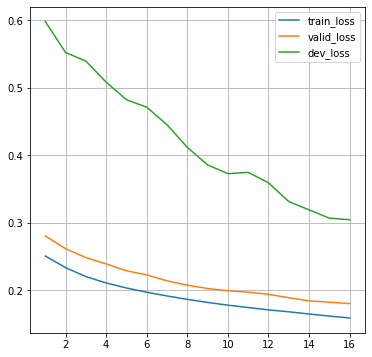

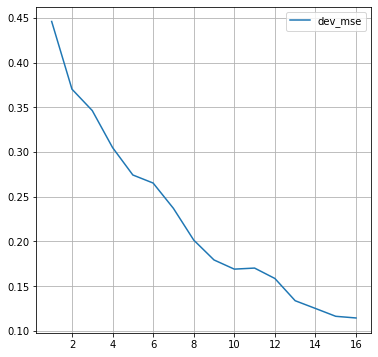

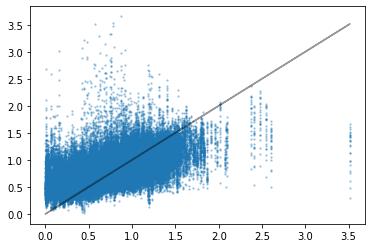

In [16]:
plotting_learning_curve(solver.history)
plotting_mse_curve(solver.history)

true, pred = make_scatter_plot(solver.predict)
plt.scatter(true, pred, alpha=0.3, s=2)
plt.plot(true, true, alpha=0.4, color='black')

# public점수 : 0.1233249592 / private점수 : 0.1304391748

# [num_relations=12]

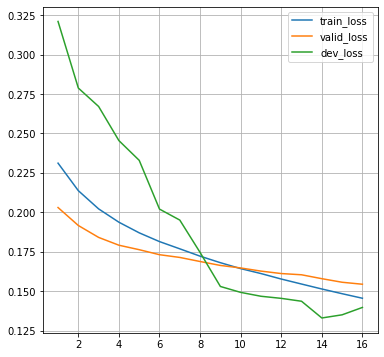

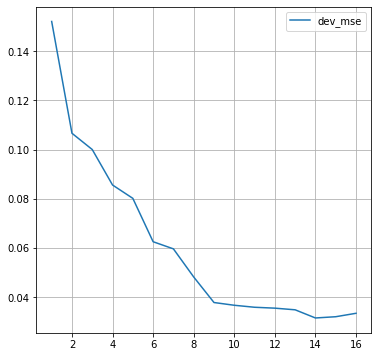

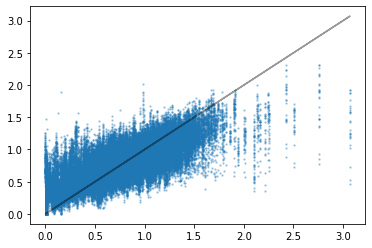

In [56]:
plotting_learning_curve(solver.history)
plotting_mse_curve(solver.history)

true, pred = make_scatter_plot(solver.predict)
plt.scatter(true, pred, alpha=0.3, s=2)
plt.plot(true, true, alpha=0.4, color='black')

In [57]:
sub = pd.read_csv(f'./data/sample_submission.csv')
test_loader = DataLoader(test_dataset,batch_size=1,shuffle=False)
model.eval()

preds = []
with torch.no_grad():
    for data in test_loader:
        data.to('cuda')
        pred = model(data.x, data.edge_index, data.edge_type, data.batch).detach().cpu().item()
        sub.loc[sub['uid'] == data.uid[0], 'ST1_GAP(eV)'] = pred
        

sub.to_csv('sub_RGCN_1.csv', index=False)

C:\Users\Tiger\anaconda3\envs\project_5\lib\site-packages\torch_geometric\deprecation.py:13: UserWarning: 'data.DataLoader' is deprecated, use 'loader.DataLoader' instead
  warnings.warn(out)


# [num_relations=24]

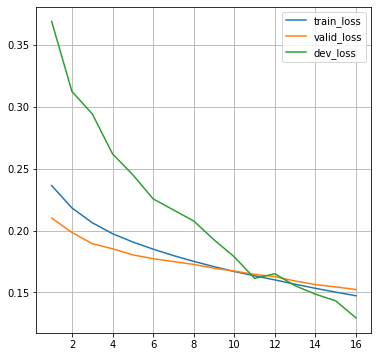

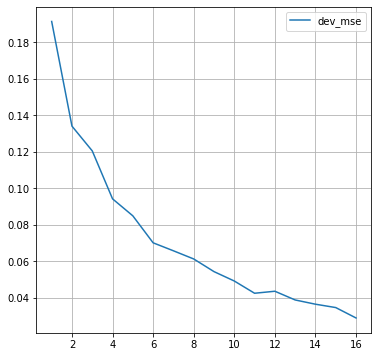

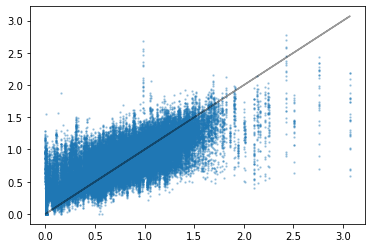

In [17]:
plotting_learning_curve(solver.history)
plotting_mse_curve(solver.history)

true, pred = make_scatter_plot(solver.predict)
plt.scatter(true, pred, alpha=0.3, s=2)
plt.plot(true, true, alpha=0.4, color='black')

# [num_relations=50]

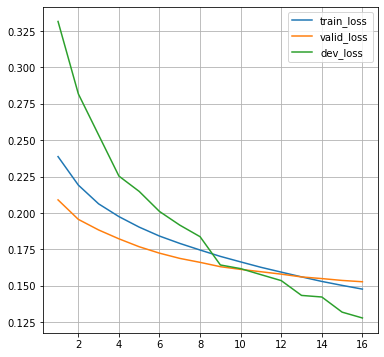

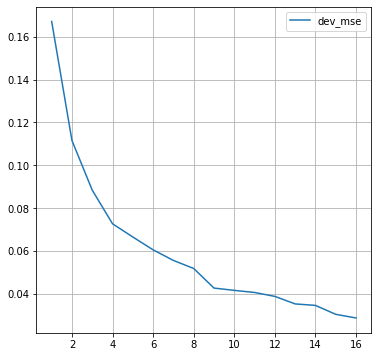

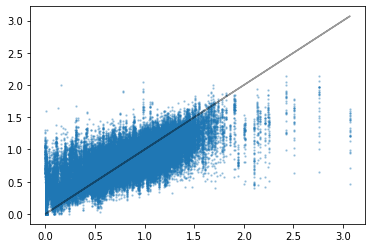

In [16]:
plotting_learning_curve(solver.history)
plotting_mse_curve(solver.history)

true, pred = make_scatter_plot(solver.predict)
plt.scatter(true, pred, alpha=0.3, s=2)
plt.plot(true, true, alpha=0.4, color='black')